## LDA machine learning assignment

Import packages 

In [102]:
# standard library
import sys,os
sys.path.append(os.path.join(".."))
from pprint import pprint
import matplotlib.pyplot as plot

# data and nlp
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm", disable=["ner"])

# visualisation
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import seaborn as sns
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 20,10


# LDA tools
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import nltk

# Stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

import lda_utils
from sklearn.decomposition import PCA

# warnings
import logging, warnings
warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package stopwords to /home/cds-
[nltk_data]     au613522/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Import data

In [83]:
# Import data from filepath 
filename = os.path.join("data", "philosophy_data.csv")
DATA = pd.read_csv(filename)
DATA[:1]

,title,author,school,sentence_spacy,sentence_str,original_publication_date,corpus_edition_date,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
0,Plato - Complete Works,Plato,plato,"What's new, Socrates, to make you leave your ...","What's new, Socrates, to make you leave your ...",-350,1997,125,"what's new, socrates, to make you leave your ...","['what', 'new', 'socrates', 'to', 'make', 'you...","what be new , Socrates , to make -PRON- lea..."


In [84]:
# Create a subset and select relevant columns in the data
DATA = DATA.iloc[:,[0,1,2,5,8]].sample(50000)
DATA.head()

,title,author,school,original_publication_date,sentence_lowered
254807,Critique Of Pure Reason,Kant,german_idealism,1781,hence pure reason is that which contains the p...
125911,The Search After Truth,Malebranche,rationalism,1674,"that effort is needed to separate them, and th..."
58314,Aristotle - Complete Works,Aristotle,aristotle,-320,at least a hunter said that out of eleven hyen...
210964,Difference And Repetition,Deleuze,continental,1968,for it is not science that is in question
282048,The Phenomenology Of Spirit,Hegel,german_idealism,1807,the former passes over in to the sceptical con...


In [85]:
"""
Each document has several entries as a line per sentences appears in the data. 
I comprise all text for each document in the same cell reducing the number of rows
in DATA to the number of documents.
"""

gathered_text = list(DATA.groupby(['title'])['sentence_lowered'].apply(lambda x: ' '.join(x)).reset_index()["sentence_lowered"])

# Only keep 1 row per document.
DATA = DATA.drop_duplicates(subset = ["title"])


# Add the new text column
DATA["text"] = gathered_text

# Drop sentence_lower column since it only contains one sentence and we now have the text column
DATA = DATA.drop("sentence_lowered", axis = 1)


59


In [104]:
# convert column with years to numeric
DATA["original_publication_date"] = pd.to_numeric(DATA["original_publication_date"])

DATA = DATA[DATA['original_publication_date'] >= 1600]
print(len(DATA))

55


In [105]:
# Building the bigram and trigram models
bigram = gensim.models.Phrases(DATA["text"], min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[DATA["text"]], min_count = 1, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

data_processed = lda_utils.process_words(DATA["text"], nlp, bigram_mod, trigram_mod,
                                         allowed_postags=['NOUN']) # consider: ['NOUN', "ADJ", "VERB", "ADV"]

In [106]:
# Create Dictionary
id2word = corpora.Dictionary(data_processed) # converts each word into an integer value (sort of like an ID)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_processed]

In [107]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics= 5, 
                                       random_state=100,
                                       chunksize=10,
                                       passes=10,
                                       iterations=100,
                                       per_word_topics=True, 
                                       minimum_probability=0.0)

In [108]:
## MODEL PERFORMANCE

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=data_processed, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.306995676431271

Coherence Score:  0.4442308404109522


In [91]:
pprint(lda_model.print_topics())

topic_df = pd.DataFrame(lda_model.print_topics(), columns=["TopicNo", "Keywords"])
topic_df
topic_df.to_csv(os.path.join("out", "Topics.csv"))

[(0,
  '0.018*"country" + 0.017*"price" + 0.016*"value" + 0.015*"part" + '
  '0.015*"labour" + 0.012*"money" + 0.012*"capital" + 0.011*"time" + '
  '0.011*"quantity" + 0.010*"trade"'),
 (1,
  '0.021*"idea" + 0.016*"object" + 0.016*"thing" + 0.015*"reason" + '
  '0.014*"nature" + 0.013*"self" + 0.011*"mind" + 0.010*"consciousness" + '
  '0.010*"concept" + 0.010*"existence"'),
 (2,
  '0.034*"woman" + 0.011*"form" + 0.009*"life" + 0.008*"body" + '
  '0.007*"history" + 0.007*"century" + 0.007*"structure" + 0.007*"madness" + '
  '0.007*"sign" + 0.006*"experience"'),
 (3,
  '0.020*"world" + 0.012*"fact" + 0.012*"way" + 0.012*"time" + 0.011*"case" + '
  '0.010*"sense" + 0.010*"word" + 0.009*"question" + 0.009*"language" + '
  '0.009*"theory"'),
 (4,
  '0.039*"man" + 0.028*"thing" + 0.014*"body" + 0.012*"part" + 0.011*"woman" + '
  '0.011*"people" + 0.009*"soul" + 0.009*"way" + 0.008*"time" + 0.008*"other"')]


In [109]:
# Creating a new DF, which assigns which topic is the most dominant, amongst all entries in the corpus
df_topic_keywords = lda_utils.format_topics_sentences(ldamodel=lda_model, 
                                                      corpus=corpus, 
                                                      texts=data_processed)

# titles, authors, schools, and year
df_topic_keywords["Title"] = list(DATA["title"])
df_topic_keywords["Author"] = list(DATA["author"])
df_topic_keywords["School"] = list(DATA["school"])
df_topic_keywords["Year"] = list(DATA["original_publication_date"])

# Format
df_topic_keywords.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text", "Title", "Author", "School", "Year"]

# Quick overview
df_topic_keywords[:5]

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text,Title,Author,School,Year
0,2.0,0.6419,"country, price, value, labour, part, money, capital, quantity, time, trade","[object, time, income, system, thing, amount, employment, study, economic, generalisat...",Critique Of Pure Reason,Kant,german_idealism,1781
1,3.0,0.9718,"thing, idea, body, mind, man, reason, nature, object, part, sense","[part, mind, idea, reflexion, power, activity, thing, motion, force, quantity, motion,...",The Search After Truth,Malebranche,rationalism,1674
2,0.0,0.6603,"woman, life, form, man, work, history, power, world, child, society","[conception, matrix, function, value, body, organ, reproduce, shoot, branch, corner, b...",Difference And Repetition,Deleuze,continental,1968
3,4.0,0.8148,"man, thing, people, way, time, part, case, life, other, body","[hyena, soul, unity, virtue, perception, unity, virtue, faculty, sense, mode, cavity, ...",The Phenomenology Of Spirit,Hegel,german_idealism,1807
4,1.0,0.9268,"world, concept, time, sense, way, fact, form, case, relation, self","[world, being, priority, question, phenomenon, attempt, point, way, time, sense, repre...",The Second Sex,Beauvoir,feminism,1949


In [94]:
df_topic_keywords[:10]

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text,Title,Author,School,Year,Topic1,Topic2,Topic3,Topic4,Topic5
0,0.0,0.7117,"country, part, price, value, labour, capital, money, trade, quantity, land","[scale, writing, opinion, regard, difficulty, claim, rank, intuition, truth, error, cl...",The Problems Of Philosophy,Russell,analytic,1912,0.711661,0.062741,0.214356,0.000061,0.011181
1,1.0,0.9658,"thing, idea, reason, object, body, mind, nature, man, sense, part","[foregoing, principle, scheme, idea, place, thing, body, substance, sense, principle, ...",The Search After Truth,Malebranche,rationalism,1674,0.000246,0.965814,0.000243,0.033457,0.000241
2,1.0,0.8937,"thing, idea, reason, object, body, mind, nature, man, sense, part","[examination, impression, clearness, idea, examination, idea, clearness, reasoning, fo...",Thus Spake Zarathustra,Nietzsche,nietzsche,1887,0.023589,0.893678,0.000033,0.082667,0.000033
3,2.0,0.6970,"world, language, time, form, way, fact, case, question, word, theory","[production, psychoanalyst, insufficiency, capitalism, action, monopoly, time, capital...",Plato - Complete Works,Plato,plato,-350,0.099386,0.013811,0.697020,0.189741,0.000042
4,3.0,0.7315,"man, woman, thing, people, life, time, body, way, child, part","[animal, lung, refrigeration, scope, deviation, amount, fire, air, account, quantity, ...",Quintessence,Quine,analytic,1950,0.010020,0.258462,0.000006,0.731506,0.000006
5,2.0,0.8818,"world, language, time, form, way, fact, case, question, word, theory","[attunement, dependence, world, kind, world, let, way, self, understanding, self, bein...",Anti-Oedipus,Deleuze,continental,1972,0.000052,0.093996,0.881805,0.000052,0.024095
6,3.0,0.6902,"man, woman, thing, people, life, time, body, way, child, part","[tortoise, day, tomorrow, firstling, century, curiosity, art, disguising, cruelty, sen...",Lewis - Papers,Lewis,analytic,1985,0.000134,0.137522,0.172037,0.690172,0.000135
7,0.0,0.7599,"country, part, price, value, labour, capital, money, trade, quantity, land","[exchange, value, sight, relation, proportion, value, sort, sort, relation, time, plac...",The Phenomenology Of Spirit,Hegel,german_idealism,1807,0.759896,0.039587,0.100720,0.089847,0.009950
8,1.0,0.8761,"thing, idea, reason, object, body, mind, nature, man, sense, part","[purposiveness, determinate, concept, judgement, concept, law, pleasure, taste, concep...",Philosophical Studies,Moore,analytic,1910,0.006483,0.876149,0.036672,0.031267,0.049429
9,1.0,0.6030,"thing, idea, reason, object, body, mind, nature, man, sense, part","[connection, world, sense, ihrem, wesen, term, punishment, sense, viz, teacher, attrib...",Three Dialogues,Berkeley,empiricism,1713,0.000112,0.602956,0.041209,0.031708,0.324016


In [110]:
# Get the probability of each topic for eery document
values = list(lda_model.get_document_topics(corpus))

In [111]:
# Split topics and keep only values per topic
split = []
for entry in values:
    topic_prevelance = []
    for topic in entry:
        topic_prevelance.append(topic[1])
    split.append(topic_prevelance)

In [112]:
# Save as df and combine with the topic keyword df
split = pd.DataFrame(split, columns=["Topic0","Topic", "Topic2", "Topic3", "Topic4"])

In [122]:
df_topic_keywords = pd.concat([df_topic_keywords, split], axis=1)

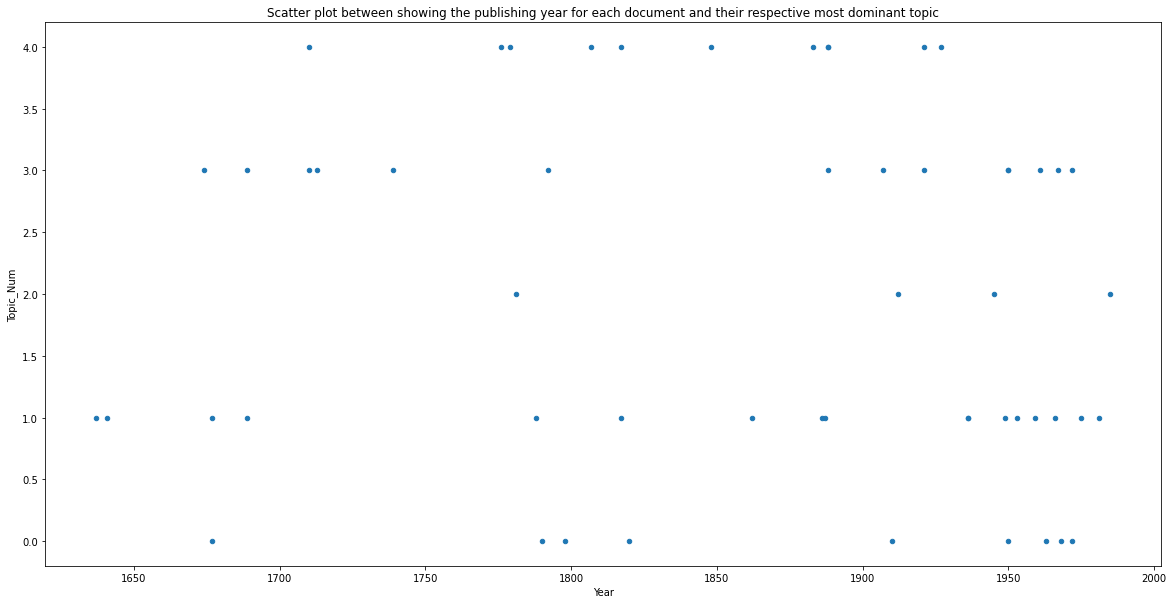

In [128]:
fig2 = df_topic_keywords.plot.scatter(x='Year', y='Topic_Num', title= "Scatter plot between showing the publishing year for each document and their respective most dominant topic")
fig2.figure.savefig(os.path.join("out", "scatter_plot.png"))

__PCA feature reduction__

In [59]:
# Reduce feature space 
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_topic_keywords.set_index("Year").iloc[:,8:])
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Principal Component 1', 'Principal Component 2'])

# Adding Year
principalDf["Year"] = df_topic_keywords["Year"]

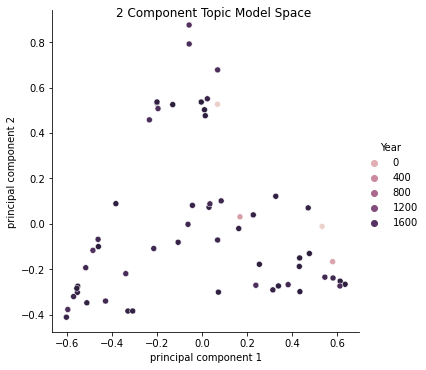

In [64]:

# I plot the PCA component scores of each document to see potential clusters spatially. Colored by year.
plot_texts_pda = sns.relplot(
    data=principalDf,
    x="principal component 1", y="principal component 2", hue = "Year").fig.suptitle("2 Component Topic Model Space")

plot_texts_pda

# Saving to out
fig = plot_texts_pda.get_figure()
fig.savefig(os.path.join("out", "PCA_plot.png"))

In [93]:
df_topic_keywords[:2]

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text,Title,Author,School,Year,Topic1,Topic2,Topic3,Topic4,Topic5
0,0.0,0.7117,"country, part, price, value, labour, capital, money, trade, quantity, land","[scale, writing, opinion, regard, difficulty, claim, rank, intuition, truth, error, cl...",The Problems Of Philosophy,Russell,analytic,1912,0.711661,0.062741,0.214356,0.000061,0.011181
1,1.0,0.9658,"thing, idea, reason, object, body, mind, nature, man, sense, part","[foregoing, principle, scheme, idea, place, thing, body, substance, sense, principle, ...",The Search After Truth,Malebranche,rationalism,1674,0.000246,0.965814,0.000243,0.033457,0.000241


In [98]:
pd.set_option('max_colwidth', 90) # Making sure we can read all the topic keywords
topic_keywords = df_topic_keywords.drop_duplicates(subset = ["Topic_Num"]).loc[:,["Topic_Num", "Keywords"]]


#Saving to out folder
topic_keywords.to_csv(os.path.join("out", "topic_keywords.csv"), index=False)